In [4]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
%matplotlib inline

import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  We said that for a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  Let's work it out:

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  We said that for a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  Let's work it out:

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).

### Gradient boosting with regression trees

The loss function to minimize is the sum of the squared residuals:

$$\frac1{n}\sum_{i=1}^n(y_i-(\alpha + \beta x_i))^2$$

(Though it can also be the sum of the absolute value of the residuals, as in lasso regression.)

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

The decision trees we use can be very simple.  In the example below, the decision trees only have a max depth of 2, meaning a maximum of four leaves.  These weak learners do not have to perform well at all individually in order to do well in aggregate.  

Here we're going to do gradient boosting with regression trees by hand.  Our goal is to predict the variable "happy" using all the other variables in the European Social Survey dataset.  We'll calculate a tree, store the predicted values, pull the residuals, and run a new tree on the residuals.  This will repeat 101 times.  At the end, we add together all the predicted values from each iteration to yield the final predictions.

Weak learner 0 R^2: -21.86595826514709
Weak learner 20 R^2: -0.0026192923008196978
Weak learner 40 R^2: -0.0016748172727345523
Weak learner 60 R^2: -0.0014818633549413818
Weak learner 80 R^2: -0.0012578370480087475
Weak learner 100 R^2: -0.0007136861925909344


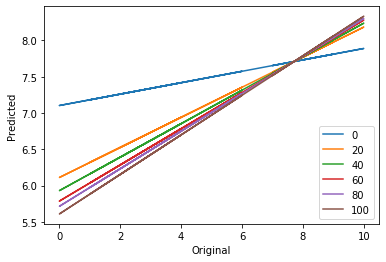

Overall R^2:
0.5282873581794291


In [5]:
# Working with the European Social Survey data again.
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Define outcome and predictors.
y = df['happy']
X = df.loc[:, ~df.columns.isin(['happy', 'cntry'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Store values from loops.
preds = pd.DataFrame()
labels = []

uniquex = df['happy'].unique()

# Iterate through decision trees, each time using the residuals
# from the previous tree as the inputs.
for m in range(0, 101):
    
    # Initialize and fit the tree. Set the max depth to 2.
    decision_tree = tree.DecisionTreeRegressor(max_depth=2)
    decision_tree.fit(X,y)
    
    # Get and store predicted values.
    pred = decision_tree.predict(X)
    preds['pred{}'.format(m)] = pred
    
    # Residuals.
    y = y - pred

    # Output every 20 iterations.
    if m % 20 == 0:
        print('Weak learner {} R^2: {}'.format(m, decision_tree.score(X, y)))
        labels = labels + [m]
        bestpred = preds.sum(axis=1)
        plt.plot(uniquex, np.poly1d(np.polyfit(df['happy'], bestpred, 1))(uniquex))
       
plt.legend(labels)
plt.xlabel('Original')
plt.ylabel('Predicted')
plt.show()
predicted = preds.sum(axis=1)

print('Overall R^2:')
print(np.corrcoef(df['happy'], predicted)[0, 1])

> Looking at the sampling of individual model $R^2$, these are certainly 'weak learners'!  They perform very badly indeed.  Yet in aggregate, the models are able to explain nearly 53% of the variance in happiness in the dataset.  This is a great example of the power of gradient boosting.  You may also note from the plot that the greatest gains happened in the earliest models, with subsequent steps yielding smaller gains in explanatory power.

> But maybe we could do just as well with one big decision tree, rather than a bunch of small ones.  Let's try:

One strongish learner R^2: 0.21072567176527268


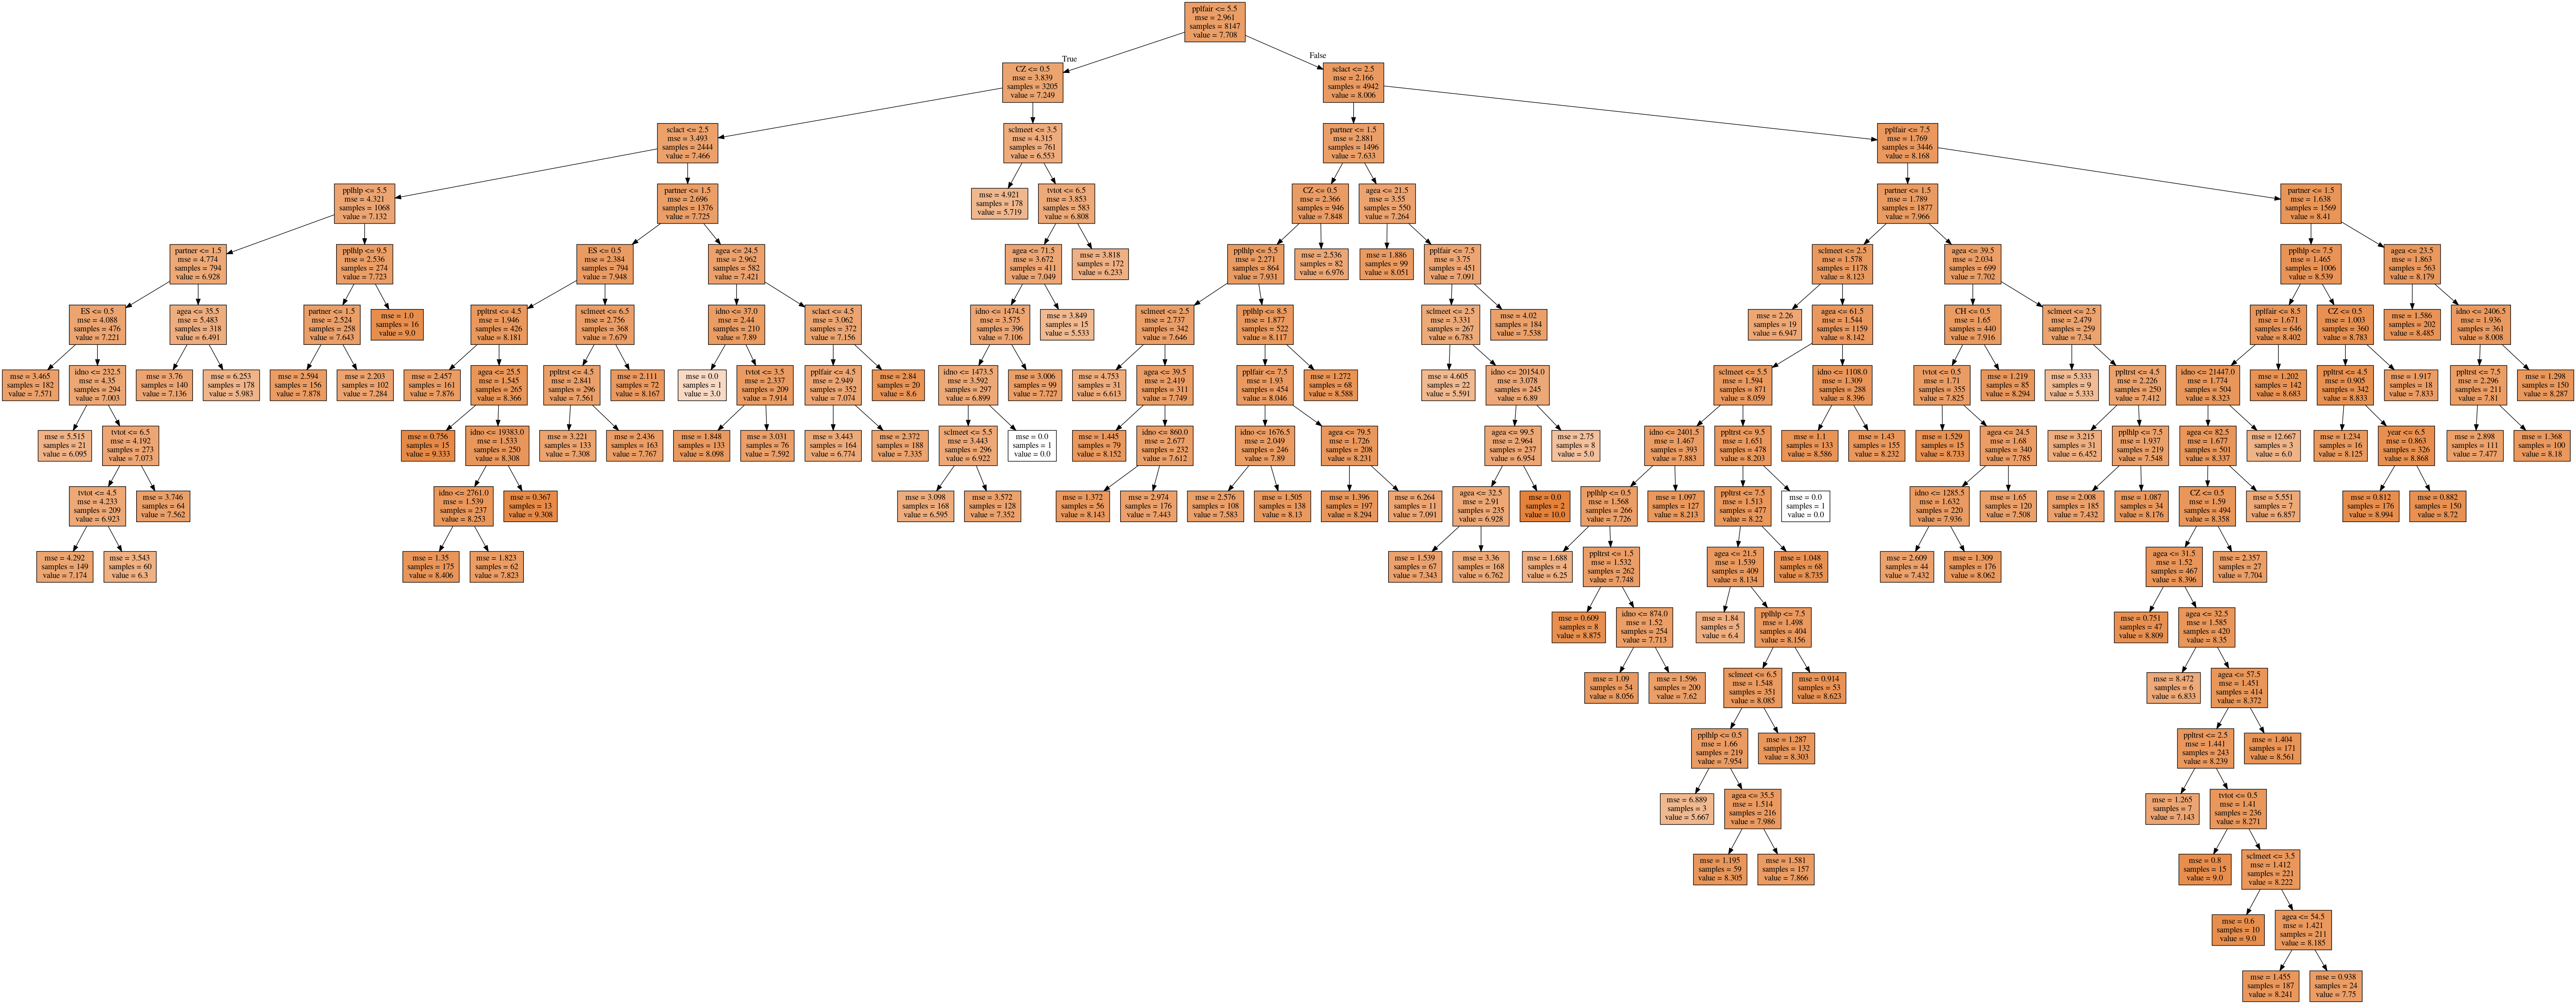

In [6]:
# One big tree. Each node split will include at lest 2.5% of the total sample.
decision_tree = tree.DecisionTreeRegressor(min_samples_split=.025)
y = df['happy']
decision_tree.fit(X,y)

#Get and store predicted values.
pred = decision_tree.predict(X)
print('One strongish learner R^2: {}'.format(decision_tree.score(X, y)))

dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names=X.columns,  
                                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())  

Well that didn't work at all.  Gradient boosting with weak learners was nearly twice as effective as one complex decision tree.  In fact, in many instances gradient boosted decision trees perform better than random forests.  They are also less prone to overfitting than individual decision trees.

### Overfitting

Still, it is easy to see that the more iterations we run, the more likely we are to overfit.  Gradient boost comes with some methods to avoid overfitting.  Cross-validation will check for overfitting, but there are also methods that can be applied before using the test set that will reduce the likelihood of overfit.  

One option is subsampling, where each iteration of the boost algorithm uses a subsample of the original data.  By introducing some randomness into the process, subsampling makes it harder to overfit.

Another option is shrinkage, which we have encountered before in ridge regression.  Here, the shrinkage/regularization parameter reduces the impact of subsequent iterations on the final solution.  Visually, you can picture this parameter, called the "learning rate", causing each "step" along the loss function gradient to be a little smaller than the previous one.  This prevents any one iteration from being too influential and misdirecting the overall boost solution.  Learning rates vary between 0 (only the initial iteration matters) to 1 (all iterations are weighted equally).  A model made up of many small steps is less prone to overfitting than a model made up of few large steps, but it can also lead to much slower running times, depending on the stopping rule in play.

In the next assignment, we'll try gradient boosting using the SKLearn package, which comes with all sorts of helpful features for getting the most out of gradient boost.

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [7]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]

> Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [8]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.

# *** It's best to update this table for the drill 
#  at the end of the lesson.  ***

params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

### Evaluation of Model - Confusion Matrix Plot

based on the example here:

https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [9]:
def plot_confusion_matrix(cm, classes,normalize, cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

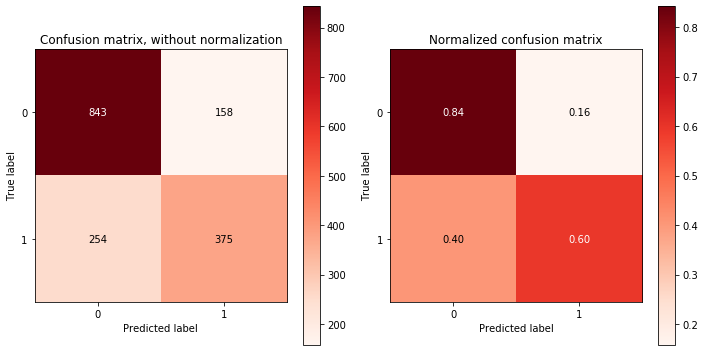

In [10]:
cm = confusion_matrix(y_test, predict_test)

plt.figure(figsize=(10,5))

# Plot non-normalized confusion matrix
plt.subplot(1,2,1)
plot_confusion_matrix(cm,[0,1],False)

# Plot normalized confusion matrix
plt.subplot(1,2,2)
plot_confusion_matrix(cm,[0,1],True)

plt.tight_layout()

# Accuracy

Returns the mean accuracy on the given test data and labels.

In multi-label classification, this is the subset accuracy which is a harsh metric since **you require for each sample that each label set be correctly predicted**. The accuracy is the ratio ``correct_predictions / total_predictions``

In [11]:
# This score will be used later for comparison
first_acc_score = clf.score(X_test, y_test)
first_acc_score

0.747239263803681

In [12]:
# Creating a y prediction variable for easier readability going forward
y_pred = predict_test

# Precision

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
true positives and ``fp`` the number of false positives. The precision is
intuitively the ability of the classifier not to label as positive a sample
that is negative.

The best value is 1 and the worst value is 0.

<font color='blue'>Precision means the percentage of your results which are relevant.</font>

In [13]:
# This score will be used later for comparison
first_prec_score = precision_score(y_test,y_pred)
first_prec_score

0.7035647279549718

# Recall

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

<font color='blue'>Recall refers to the percentage of total relevant results correctly classified by your algorithm</font>

In [14]:
# This score will be used later for comparison
first_rec_score = recall_score(y_test, y_pred)
first_rec_score

0.5961844197138315

> Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

# More on Precision and Recall
+ Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

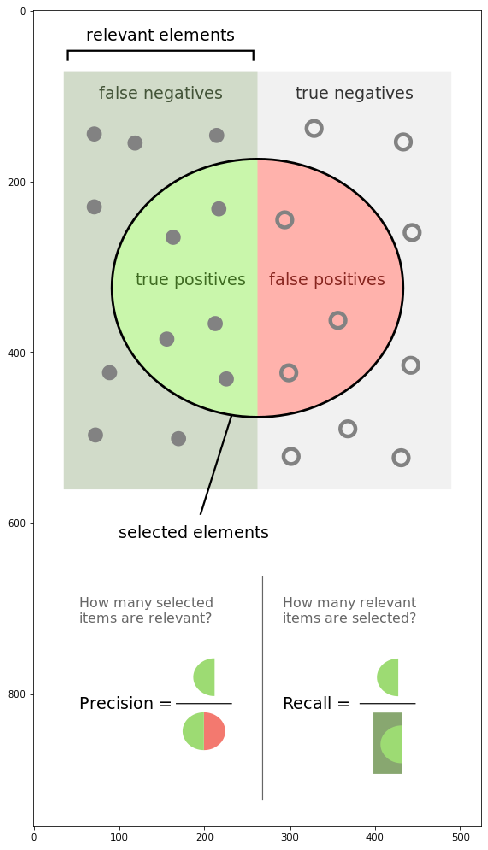

In [15]:
import matplotlib.image as mpimg

img = mpimg.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png')
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

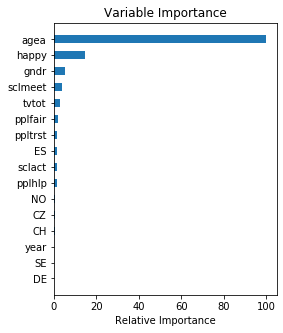

In [16]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(4,5))
plt.barh(pos, feature_importance[sorted_idx], height=0.5, align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

> It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, but there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

You can learn more about the parameters for the gradient boost model [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and update the **params** table featured earlier, before we initialized and fit the model.

A few parameters to tune could be:
 - learning_rate
 - max_depth
 - n_estimators
 - loss
 - subsample
 - min_samples_split
 
You can then use the same metrics to evaluate your results.
          
Have fun!

In [19]:
from itertools import product
from tqdm import tqdm

# We started with 500 iterations, using 2-deep trees, and set our loss function to 'deviance'.
# What changes can lead to improvements in the model?

#### Re-run this cell to test modifications with the algorithm and the dataset

hyperparams = dict(
    n_estimators = [125, 250, 500, 1000],
    learning_rate = [0.0125, 0.025, 0.05, 0.1],
    max_depth = [2, 3, 4, 5],
    max_features = [1,2,3],
    loss = ['deviance'], #['deviance', 'exponential']
)

f_1 = 0

for n_estimators, learning_rate, max_depth, loss in tqdm(list(product(*[hyperparams[k] for k in 'n_estimators learning_rate max_depth loss'.split()]))):
    params = {'n_estimators': n_estimators, # Originally 500
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              #'subsample':0.99,
              'loss': loss}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    acc_score = clf.score(X_test, y_test)
    prec_score = precision_score(y_test,y_pred)
    rec_score = recall_score(y_test, y_pred)
    
    # F1 score is the harmonic mean of the precision and recall, ie.the reciprocal of the arithmetic mean of the 
    # reciprocals of the given set of observations, where an F1 score reaches its best value at 1 (perfect precision 
    # and recall) and worst at 0.
    # Example: 
    #     arithmetic mean of 1, 4 and 4: (1 + 4 + 4)/3 becomes harmonic mean: (1**-1 + 4**-1 + 4**-1)/3 
    #                                 => 3/(1/1 + 1/4 + 1/4) => 3/1.5 => the answer: 2
    #     arithmetic mean of precision and recall: (p + r)/2 => 2/(1/p + 1/r) => 2*(1/[(p + r)/(p * r)])
    #                                           => 2 * (p * r)/(p + r)
    f1_score = 2 * (prec_score * rec_score)/(prec_score + rec_score)
    
    if f_1 <= f1_score:        
        print(n_estimators, learning_rate, max_depth, loss)
        print('Accuracy %1.3f | Improvement %1.3f' % (acc_score, acc_score - first_acc_score))
        print('Precision %1.3f | Improvement %1.3f' % (prec_score, prec_score - first_prec_score))
        print('Recall %1.3f | Improvement %1.3f' % (rec_score, rec_score - first_rec_score))
        print('-' * 50)
        print('F1 Score: %1.3f' % f1_score)
        
        f_1 = f1_score

  2%|▏         | 1/64 [00:00<00:21,  2.89it/s]

125 0.0125 2 deviance
Accuracy 0.735 | Improvement -0.012
Precision 0.787 | Improvement 0.084
Recall 0.429 | Improvement -0.167
--------------------------------------------------
F1 Score: 0.556


  3%|▎         | 2/64 [00:00<00:24,  2.49it/s]

125 0.0125 3 deviance
Accuracy 0.743 | Improvement -0.004
Precision 0.807 | Improvement 0.103
Recall 0.439 | Improvement -0.157
--------------------------------------------------
F1 Score: 0.568


  5%|▍         | 3/64 [00:01<00:31,  1.95it/s]

125 0.0125 4 deviance
Accuracy 0.746 | Improvement -0.001
Precision 0.823 | Improvement 0.119
Recall 0.436 | Improvement -0.161
--------------------------------------------------
F1 Score: 0.570


  6%|▋         | 4/64 [00:02<00:41,  1.45it/s]

125 0.0125 5 deviance
Accuracy 0.752 | Improvement 0.005
Precision 0.802 | Improvement 0.098
Recall 0.475 | Improvement -0.121
--------------------------------------------------
F1 Score: 0.597


 12%|█▎        | 8/64 [00:05<00:47,  1.18it/s]

125 0.025 5 deviance
Accuracy 0.755 | Improvement 0.008
Precision 0.766 | Improvement 0.063
Recall 0.526 | Improvement -0.070
--------------------------------------------------
F1 Score: 0.624


 17%|█▋        | 11/64 [00:07<00:37,  1.42it/s]

125 0.05 4 deviance
Accuracy 0.757 | Improvement 0.010
Precision 0.753 | Improvement 0.049
Recall 0.552 | Improvement -0.045
--------------------------------------------------
F1 Score: 0.637


 22%|██▏       | 14/64 [00:09<00:30,  1.62it/s]

125 0.1 3 deviance
Accuracy 0.755 | Improvement 0.008
Precision 0.734 | Improvement 0.030
Recall 0.574 | Improvement -0.022
--------------------------------------------------
F1 Score: 0.644


 25%|██▌       | 16/64 [00:11<00:38,  1.24it/s]

125 0.1 5 deviance
Accuracy 0.740 | Improvement -0.007
Precision 0.674 | Improvement -0.030
Recall 0.631 | Improvement 0.035
--------------------------------------------------
F1 Score: 0.652


 67%|██████▋   | 43/64 [01:00<00:56,  2.70s/it]

500 0.05 4 deviance
Accuracy 0.742 | Improvement -0.006
Precision 0.677 | Improvement -0.026
Recall 0.631 | Improvement 0.035
--------------------------------------------------
F1 Score: 0.653


 91%|█████████ | 58/64 [02:07<00:29,  4.84s/it]

1000 0.05 3 deviance
Accuracy 0.728 | Improvement -0.019
Precision 0.639 | Improvement -0.064
Recall 0.679 | Improvement 0.083
--------------------------------------------------
F1 Score: 0.658


100%|██████████| 64/64 [02:43<00:00,  6.28s/it]


# Conclusion

So we have some options here, depending on which score we care to maximize. From an ``F1 Score`` standpoint, our most recent printout is our best option. However, previous iterations might be better, say, if we prioritize precision over recall yet stilll want to maximize ``F1 Score``.

In [17]:
######## Adding 'max_features to the params #######

hyperparams = dict(
    n_estimators = [125, 250, 500, 1000],
    learning_rate = [0.0125, 0.025, 0.05, 0.1],
    max_depth = [2, 3, 4, 5],
    max_features = [12,13,14],
    loss = ['deviance'], #['deviance', 'exponential']
)

f_1 = 0

for n_estimators, learning_rate, max_depth, max_features, loss in tqdm(list(product(*[hyperparams[k] for k in 'n_estimators learning_rate max_depth max_features loss'.split()]))):
    params = {'n_estimators': n_estimators, # Originally 500
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'max_features': max_features,
              #'subsample':0.99,
              'loss': loss}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    acc_score = clf.score(X_test, y_test)
    prec_score = precision_score(y_test,y_pred)
    rec_score = recall_score(y_test, y_pred)
    
    f1_score = 2 * (prec_score * rec_score)/(prec_score + rec_score)
    
    if f_1 <= f1_score:        
        print(n_estimators, learning_rate, max_depth, max_features, loss)
        print('Accuracy %1.3f | Improvement %1.3f' % (acc_score, acc_score - first_acc_score))
        print('Precision %1.3f | Improvement %1.3f' % (prec_score, prec_score - first_prec_score))
        print('Recall %1.3f | Improvement %1.3f' % (rec_score, rec_score - first_rec_score))
        print('-' * 50)
        print('F1 Score: %1.3f' % f1_score)
        
        f_1 = f1_score

  1%|          | 1/192 [00:00<00:58,  3.25it/s]

125 0.0125 2 12 deviance
Accuracy 0.731 | Improvement -0.017
Precision 0.768 | Improvement 0.065
Recall 0.432 | Improvement -0.164
--------------------------------------------------
F1 Score: 0.553


  2%|▏         | 3/192 [00:00<00:57,  3.28it/s]

125 0.0125 2 14 deviance
Accuracy 0.732 | Improvement -0.015
Precision 0.770 | Improvement 0.066
Recall 0.436 | Improvement -0.161
--------------------------------------------------
F1 Score: 0.556


  2%|▏         | 4/192 [00:01<01:05,  2.88it/s]

125 0.0125 3 12 deviance
Accuracy 0.742 | Improvement -0.006
Precision 0.806 | Improvement 0.102
Recall 0.436 | Improvement -0.161
--------------------------------------------------
F1 Score: 0.566


  3%|▎         | 6/192 [00:02<01:16,  2.42it/s]

125 0.0125 3 14 deviance
Accuracy 0.741 | Improvement -0.006
Precision 0.802 | Improvement 0.098
Recall 0.437 | Improvement -0.159
--------------------------------------------------
F1 Score: 0.566


  4%|▎         | 7/192 [00:02<01:30,  2.04it/s]

125 0.0125 4 12 deviance
Accuracy 0.745 | Improvement -0.002
Precision 0.813 | Improvement 0.109
Recall 0.442 | Improvement -0.154
--------------------------------------------------
F1 Score: 0.573


  4%|▍         | 8/192 [00:03<01:42,  1.80it/s]

125 0.0125 4 13 deviance
Accuracy 0.747 | Improvement -0.001
Precision 0.805 | Improvement 0.102
Recall 0.453 | Improvement -0.143
--------------------------------------------------
F1 Score: 0.580


  5%|▌         | 10/192 [00:05<02:13,  1.37it/s]

125 0.0125 5 12 deviance
Accuracy 0.749 | Improvement 0.002
Precision 0.793 | Improvement 0.089
Recall 0.474 | Improvement -0.122
--------------------------------------------------
F1 Score: 0.593


  6%|▋         | 12/192 [00:07<02:41,  1.12it/s]

125 0.0125 5 14 deviance
Accuracy 0.754 | Improvement 0.007
Precision 0.805 | Improvement 0.101
Recall 0.479 | Improvement -0.118
--------------------------------------------------
F1 Score: 0.600


 11%|█▏        | 22/192 [00:13<02:08,  1.32it/s]

125 0.025 5 12 deviance
Accuracy 0.756 | Improvement 0.009
Precision 0.768 | Improvement 0.064
Recall 0.526 | Improvement -0.070
--------------------------------------------------
F1 Score: 0.625


 12%|█▎        | 24/192 [00:15<02:32,  1.10it/s]

125 0.025 5 14 deviance
Accuracy 0.757 | Improvement 0.010
Precision 0.773 | Improvement 0.069
Recall 0.525 | Improvement -0.072
--------------------------------------------------
F1 Score: 0.625


 16%|█▌        | 31/192 [00:18<01:29,  1.80it/s]

125 0.05 4 12 deviance
Accuracy 0.758 | Improvement 0.011
Precision 0.759 | Improvement 0.056
Recall 0.547 | Improvement -0.049
--------------------------------------------------
F1 Score: 0.636


 17%|█▋        | 32/192 [00:19<01:41,  1.58it/s]

125 0.05 4 13 deviance
Accuracy 0.760 | Improvement 0.012
Precision 0.759 | Improvement 0.056
Recall 0.552 | Improvement -0.045
--------------------------------------------------
F1 Score: 0.639


 19%|█▉        | 36/192 [00:22<02:19,  1.12it/s]

125 0.05 5 14 deviance
Accuracy 0.750 | Improvement 0.002
Precision 0.719 | Improvement 0.015
Recall 0.577 | Improvement -0.019
--------------------------------------------------
F1 Score: 0.640


 23%|██▎       | 44/192 [00:26<01:20,  1.83it/s]

125 0.1 4 13 deviance
Accuracy 0.748 | Improvement 0.001
Precision 0.701 | Improvement -0.002
Recall 0.604 | Improvement 0.008
--------------------------------------------------
F1 Score: 0.649


 43%|████▎     | 82/192 [01:10<02:40,  1.46s/it]

250 0.05 5 12 deviance
Accuracy 0.736 | Improvement -0.011
Precision 0.665 | Improvement -0.039
Recall 0.638 | Improvement 0.041
--------------------------------------------------
F1 Score: 0.651


 46%|████▌     | 88/192 [01:18<01:48,  1.05s/it]

250 0.1 3 12 deviance
Accuracy 0.742 | Improvement -0.005
Precision 0.679 | Improvement -0.025
Recall 0.631 | Improvement 0.035
--------------------------------------------------
F1 Score: 0.654


 65%|██████▌   | 125/192 [02:35<02:04,  1.86s/it]

500 0.05 3 13 deviance
Accuracy 0.752 | Improvement 0.004
Precision 0.700 | Improvement -0.004
Recall 0.623 | Improvement 0.027
--------------------------------------------------
F1 Score: 0.659


 84%|████████▍ | 161/192 [04:36<01:55,  3.72s/it]

1000 0.025 3 13 deviance
Accuracy 0.748 | Improvement 0.001
Precision 0.690 | Improvement -0.014
Recall 0.633 | Improvement 0.037
--------------------------------------------------
F1 Score: 0.660


 90%|████████▉ | 172/192 [05:28<01:13,  3.67s/it]

1000 0.05 3 12 deviance
Accuracy 0.742 | Improvement -0.005
Precision 0.669 | Improvement -0.034
Recall 0.657 | Improvement 0.060
--------------------------------------------------
F1 Score: 0.663


100%|██████████| 192/192 [07:10<00:00,  6.73s/it]


> We see a slightly improved F1 score with the additon of $max\_features$